# 1. 데이터셋 개요 (Data Description)

본 분석은 무역 데이터(`train.csv`)를 활용하여 진행됩니다. 데이터셋의 각 컬럼에 대한 상세 정보는 다음과 같습니다.

| 컬럼명 (Column) | 한글명 | 데이터 설명 | 비고 |
| :--- | :--- | :--- | :--- |
| **item_id** | 품목 ID | 개별 무역 품목을 식별하는 고유 코드 | 익명화 처리됨 |
| **year** | 연도 | 거래가 발생한 연도 | |
| **month** | 월 | 거래가 발생한 월 | |
| **seq** | 차수/순번 | 해당 연/월 내에서 발생한 거래의 순번 | |
| **type** | 유형 코드 | 무역의 유형을 나타내는 코드 | (예: 수출/수입 구분 등) |
| **hs4** | HS Code (4단위) | 국제 통일 상품 분류 체계(HS)의 4단위 코드 | 품목의 카테고리 정보 |
| **weight** | 중량 | 거래된 품목의 무게 | |
| **quantity** | 수량 | 거래된 품목의 개수 또는 수량 | |
| **value** | 무역 금액 | 거래된 품목의 금전적 가치 | **Target (예측 대상)** |

Data Shape: (10836, 9)

Data Types:
 item_id      object
year          int64
month         int64
seq         float64
type          int64
hs4           int64
weight      float64
quantity    float64
value       float64
dtype: object

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB

Descriptive Statistics:
                year         month           seq     type           hs4  \
count  10836.000000  10836.000000  10836.000000  10836.0  10

<Figure size 1000x600 with 0 Axes>

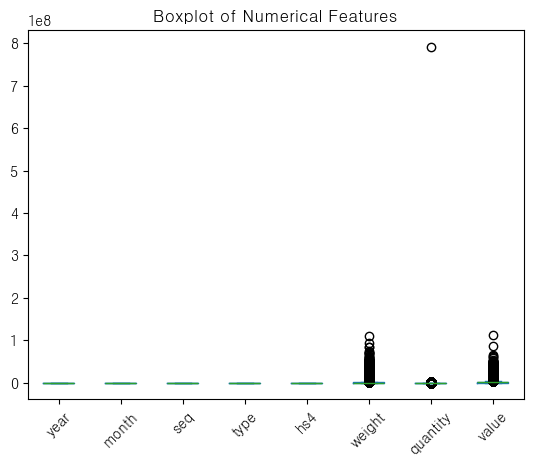

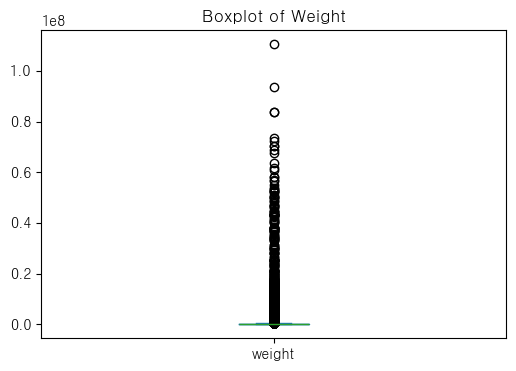

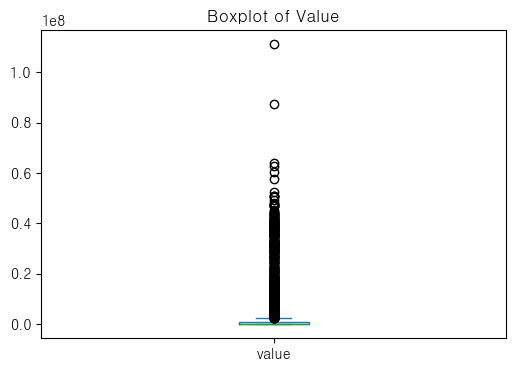

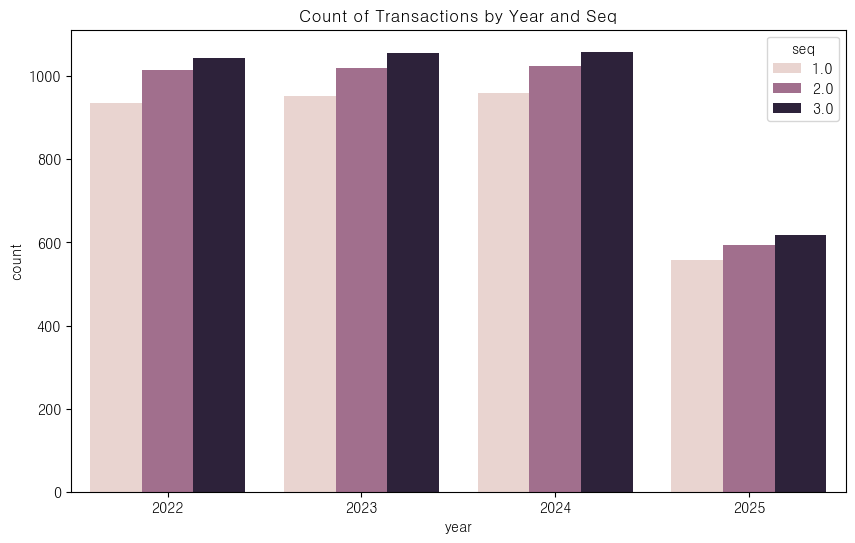

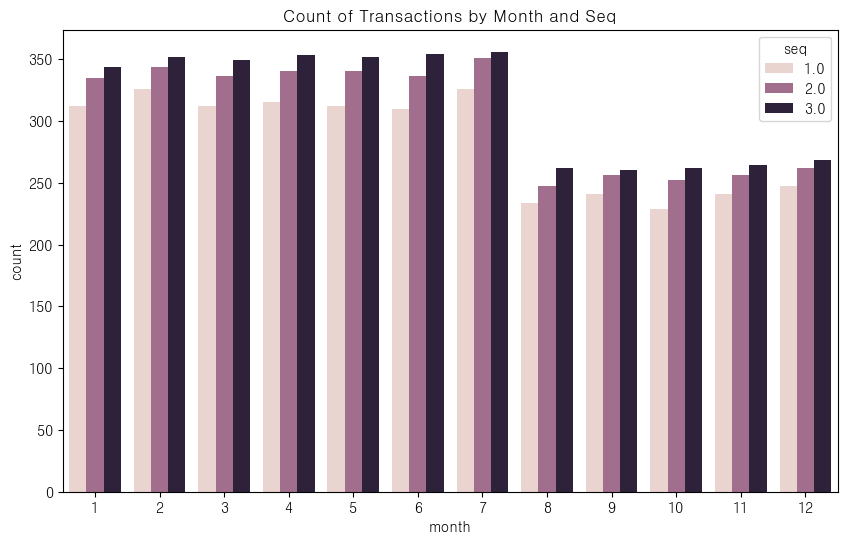

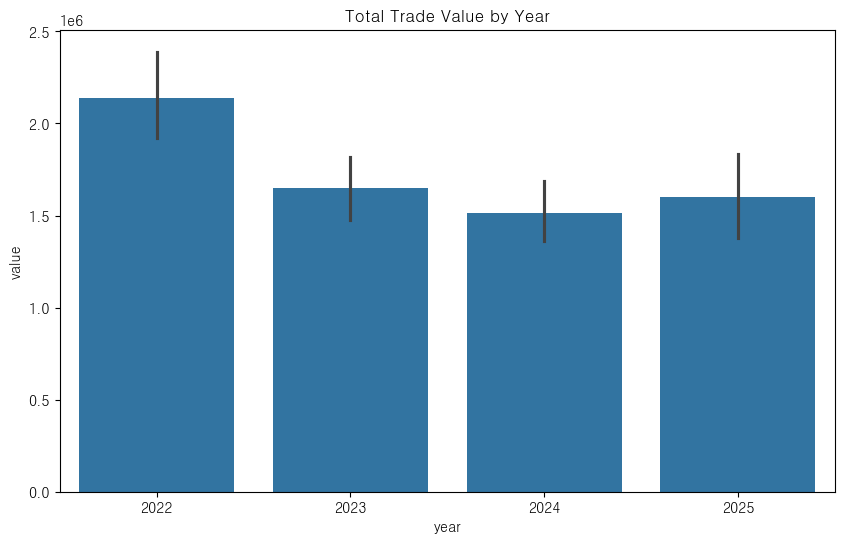

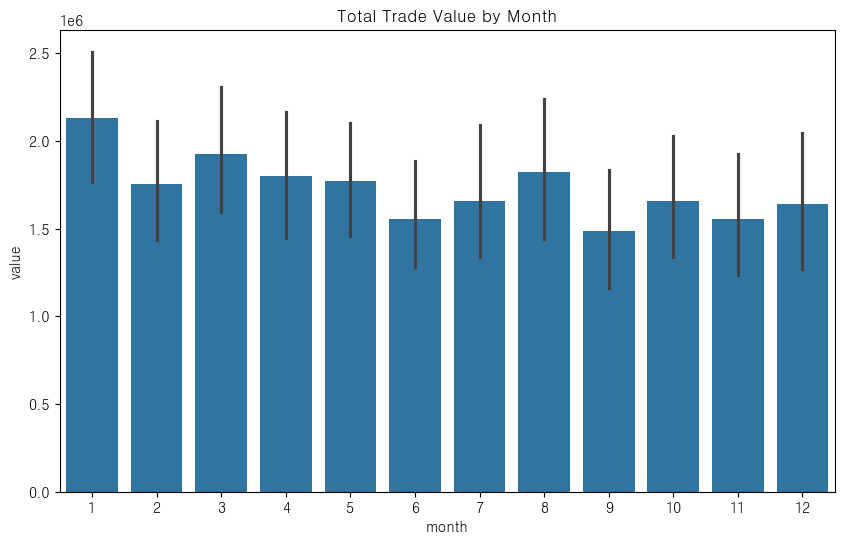

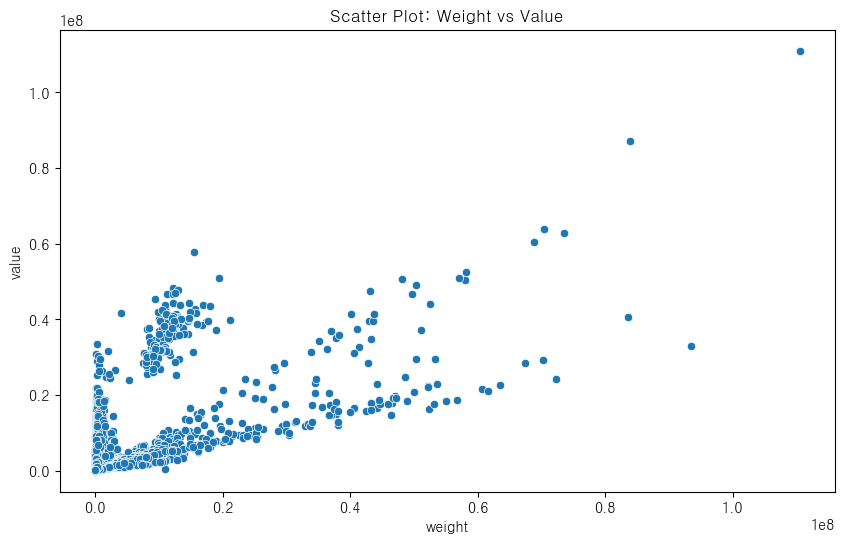

top14_hs4=2833, 1개 아이템, ['LUENUFGA']
index = 49, 1th item, item name: LUENUFGA


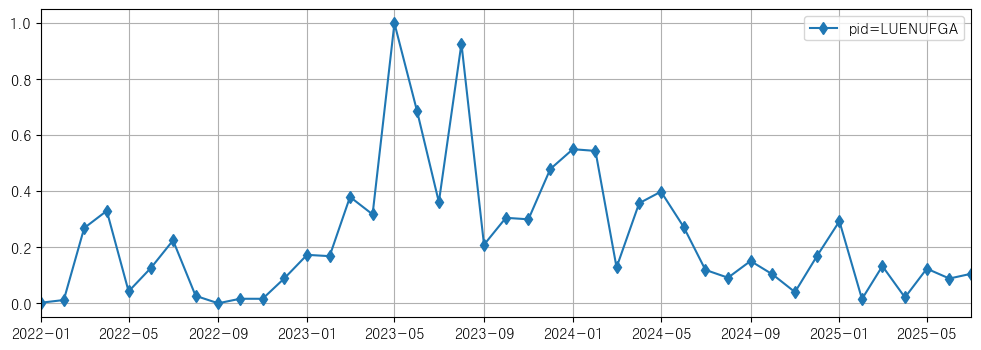

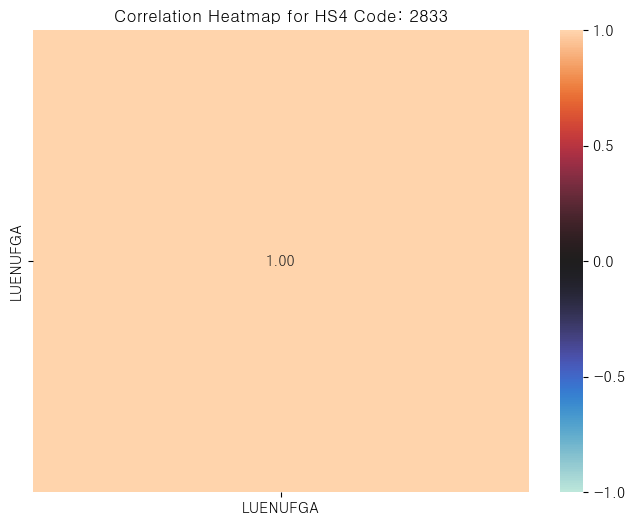

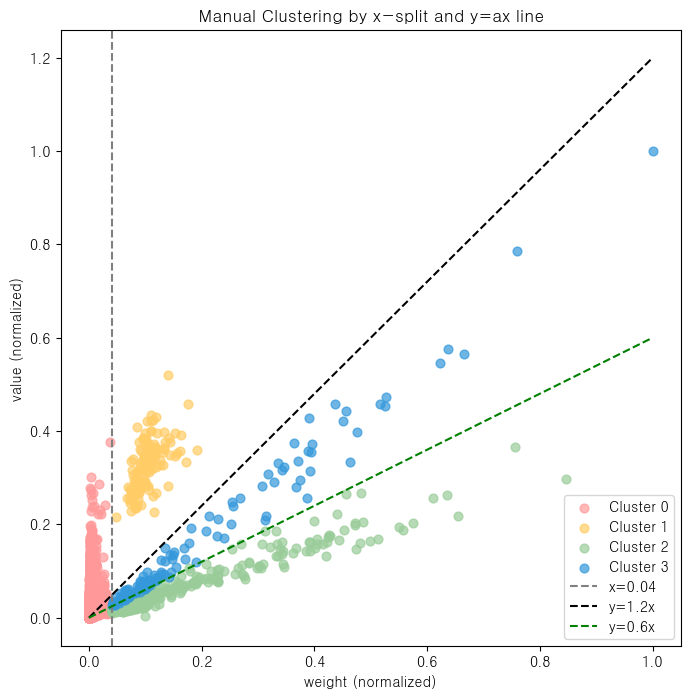

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
import plotly.express as px

# 한글 폰트 설정
font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS 폰트 경로
font_prop = fm.FontProperties(fname = font_path) 
font_name = font_prop.get_name() # 폰트명
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

# 데이터 로드
try:
    train = pd.read_csv('../data/train.csv')
except FileNotFoundError:
     train = pd.read_csv('train.csv')

# 데이터 구조 확인
print("Data Shape:", train.shape)
print("\nData Types:\n", train.dtypes)
print("\nInfo:\n")
train.info()

# 기술 통계
print("\nDescriptive Statistics:\n", train.describe())
print("\nObject Type Statistics:\n", train.describe(include='object'))

# 결측치 확인
print("\nMissing Values:\n", train.isna().sum())

# 이상치 확인 (Boxplot)
plt.figure(figsize=(10, 6))
train.plot(kind='box')
plt.xticks(rotation=45)
plt.title("Boxplot of Numerical Features") # 제목 추가
plt.show()


# weight, value Boxplot
plt.figure(figsize=(6, 4))
train['weight'].plot(kind='box')
plt.title("Boxplot of Weight")
plt.show()

plt.figure(figsize=(6, 4))
train['value'].plot(kind='box')
plt.title("Boxplot of Value")
plt.show()


# 연도별 거래 횟수 (seq 기준)
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="year", hue="seq")
plt.title("Count of Transactions by Year and Seq")
plt.show()

# 월별 거래 횟수 (seq 기준)
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="month", hue="seq")
plt.title("Count of Transactions by Month and Seq")
plt.show()

# 연도별 총 무역량
plt.figure(figsize=(10, 6))
sns.barplot(data=train, x="year", y="value")
plt.title("Total Trade Value by Year")
plt.show()

# 월별 총 무역량
plt.figure(figsize=(10, 6))
sns.barplot(data=train, x="month", y="value")
plt.title("Total Trade Value by Month")
plt.show()


# weight, value 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x="weight", y="value") 
plt.title("Scatter Plot: Weight vs Value")
plt.show()

# 월별 무역량 피벗 테이블 생성 및 시각화 (1)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2) 
)

pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

# seq 분류
seq_pivot_df_cnt = pd.pivot_table(train, index='item_id', columns="month", values='seq',aggfunc='count', margins=True, margins_name="seq_total")

tmp_ser = seq_pivot_df_cnt['seq_total'].iloc[:-1]
dct_seq_total = pd.cut(tmp_ser, bins= [0, 40, 80, tmp_ser.max()], labels = ['seq_cnt_low',  'seq_cnt_mid',  'seq_cnt_high'] ).to_dict()

train_fe = train.copy()
train_fe['seq_cat'] = train_fe["item_id"].map(dct_seq_total)
monthly_fe = monthly.copy()
monthly_fe["seq_cat"] = monthly_fe['item_id'].map(dct_seq_total)

tmp_df_seq = train_fe.groupby(["seq_cat"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['seq_cat_len'] = train_fe.groupby(["seq_cat"])["item_id"].apply(lambda x: len(np.unique(x))).values

dct_seq_cat = tmp_df_seq[['seq_cat','item_id']].set_index('seq_cat').to_dict()['item_id']
topN_seq_cat = tmp_df_seq['seq_cat'].values

# 상관관계 높은 아이템 찾기
corr_matrix = pivot.T.corr()
high_corr = []
for i, row in enumerate(corr_matrix[(abs(corr_matrix) >= 0.7) & corr_matrix[(abs(corr_matrix) < 0.99)]].iterrows()):
    if row[1].any():
        #print(( row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))
        high_corr.append((row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))
dict_hight_corr = dict(high_corr)


# 특정 hs4 코드에 대한 아이템 시계열 시각화 및 상관관계 히트맵
sel_topN_hs4 = 14 # 예시 인덱스
# hs4 관련 코드 (이전 문맥에 없어서 추가하거나 수정 필요. 여기서는 가정)
# 만약 dct_hs4_tmp_df와 topN_hs4가 정의되어 있지 않다면 이 부분은 실행되지 않을 수 있습니다.
# 아래 코드는 문맥상 필요한 변수들이 정의되어 있다고 가정하고 작성되었습니다.
# 예를 들어:
hs4_group = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
dct_hs4_tmp_df = hs4_group.set_index('hs4').to_dict()['item_id']
topN_hs4 = hs4_group['hs4'].values


if sel_topN_hs4 <= len(topN_hs4):
    target_hs4 = topN_hs4[sel_topN_hs4-1]
    print(f"top{sel_topN_hs4}_hs4={target_hs4}, {len(dct_hs4_tmp_df[target_hs4])}개 아이템, {dct_hs4_tmp_df[target_hs4]}")

    df_hm_plot = pd.DataFrame()
    
    j= 0
    fig = plt.figure(figsize=(12,4))
    for i, group in enumerate(monthly.groupby("item_id")[['item_id','ym', 'value']]):
        if group[0] in dct_hs4_tmp_df[target_hs4]:
            j += 1
            print(f'index = {i+1}, {j}th item, item name: {group[0]}')
    
            #df_hm_plot = pd.concat([df_hm_plot, group[1]], axis=0) # concat 방식 변경 필요할 수 있음. 여기서는 pivot된 형태로 붙이는게 나을 듯.
            # 대신 pivot 데이터를 활용
            if group[0] in pivot.index:
                 df_hm_plot[group[0]] = pivot.loc[group[0]]
                 
                 ax = plt.gca()
                 # 정규화 하여 plotting
                 ax.plot(pivot.columns, (pivot.loc[group[0]] - pivot.loc[group[0]].min()) / (pivot.loc[group[0]].max() - pivot.loc[group[0]].min()), label=f'pid={group[0]}', marker='d')
    
    if not df_hm_plot.empty:
        ax.set_xlim([monthly['ym'].min(), monthly['ym'].max()])
        ax.legend()
        ax.grid()
        plt.show()

        fig_sns = plt.figure(figsize=(8,6))
        # df_hm_plot은 index가 ym이고 columns가 item_id인 형태여야 함.
        corr_mat= df_hm_plot.corr()
        sns.heatmap(corr_mat, annot=True, fmt=".2f",vmin=-1, vmax=1, cbar_kws={'ticks': [-1, -0.5, 0, 0.5, 1]}, center=0)
        plt.title(f"Correlation Heatmap for HS4 Code: {target_hs4}")
        plt.show()
    else:
        print("No items found for this HS4 code.")
else:
    print("Invalid index for topN_hs4")

# Manual Clustering
x = train['weight'] / train['weight'].max()
y = train['value'] / train['value'].max()
x_split = 0.04
a = 1.2
b = 0.6
train['cluster_manual'] = 0
train.loc[(x <= x_split), 'cluster_manual'] = 0
train.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1
train.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2
train.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3

plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[train['cluster_manual']==i], y[train['cluster_manual']==i], label=f'Cluster {i}', s=40, color=color, alpha=0.7)
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100), a * np.linspace(0,1,100), color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100), b * np.linspace(0,1,100), color='green', linestyle='--', label=f'y={b}x')
plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()